# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=imprint', 'case/server=malicious-model',
                                                      'case=3_small_batch_imagenet'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=torch.float)
setup

Investigating use case small_batch_imagenet with server type malicious_model.
Attack settings are:
type: analytic
attack_type: imprint-readout



{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
cfg.case.user.data_idx = 200
cfg.case.model='resnet18'

cfg.case.user.num_data_points = 64
cfg.case.server.model_modification.type = 'ImprintBlock' 
cfg.case.server.model_modification.num_bins = 128
cfg.case.server.model_modification.position = '2.0.conv'  #3.0.conv?


cfg.case.server.has_external_data = False

### Instantiate all parties

In [4]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Block inserted at feature shape torch.Size([64, 56, 56]).
Model architecture <class 'torchvision.models.resnet.ResNet'> loaded with 63,270,568 parameters and 9,620 buffers.
Overall this is a data ratio of       7:1 for target shape [64, 3, 224, 224] given that num_queries=1.


In [5]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of data points: 64
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: ResNet
            loss function: CrossEntropyLoss()

            Data:
            Dataset: ImageNet
            data_idx: 200
        


### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

[('hammerhead', 'hammerhead shark'), ('electric ray', 'crampfish', 'numbfish', 'torpedo'), ('stingray',), ('cock',), ('hen',), ('ostrich', 'Struthio camelus'), ('brambling', 'Fringilla montifringilla'), ('goldfinch', 'Carduelis carduelis'), ('house finch', 'linnet', 'Carpodacus mexicanus'), ('junco', 'snowbird'), ('indigo bunting', 'indigo finch', 'indigo bird', 'Passerina cyanea'), ('robin', 'American robin', 'Turdus migratorius'), ('bulbul',), ('jay',), ('magpie',), ('chickadee',), ('water ouzel', 'dipper'), ('kite',), ('bald eagle', 'American eagle', 'Haliaeetus leucocephalus'), ('vulture',), ('great grey owl', 'great gray owl', 'Strix nebulosa'), ('European fire salamander', 'Salamandra salamandra'), ('common newt', 'Triturus vulgaris'), ('eft',), ('spotted salamander', 'Ambystoma maculatum'), ('axolotl', 'mud puppy', 'Ambystoma mexicanum'), ('bullfrog', 'Rana catesbeiana'), ('tree frog', 'tree-frog'), ('tailed frog', 'bell toad', 'ribbed toad', 'tailed toad', 'Ascaphus trui'), ('l

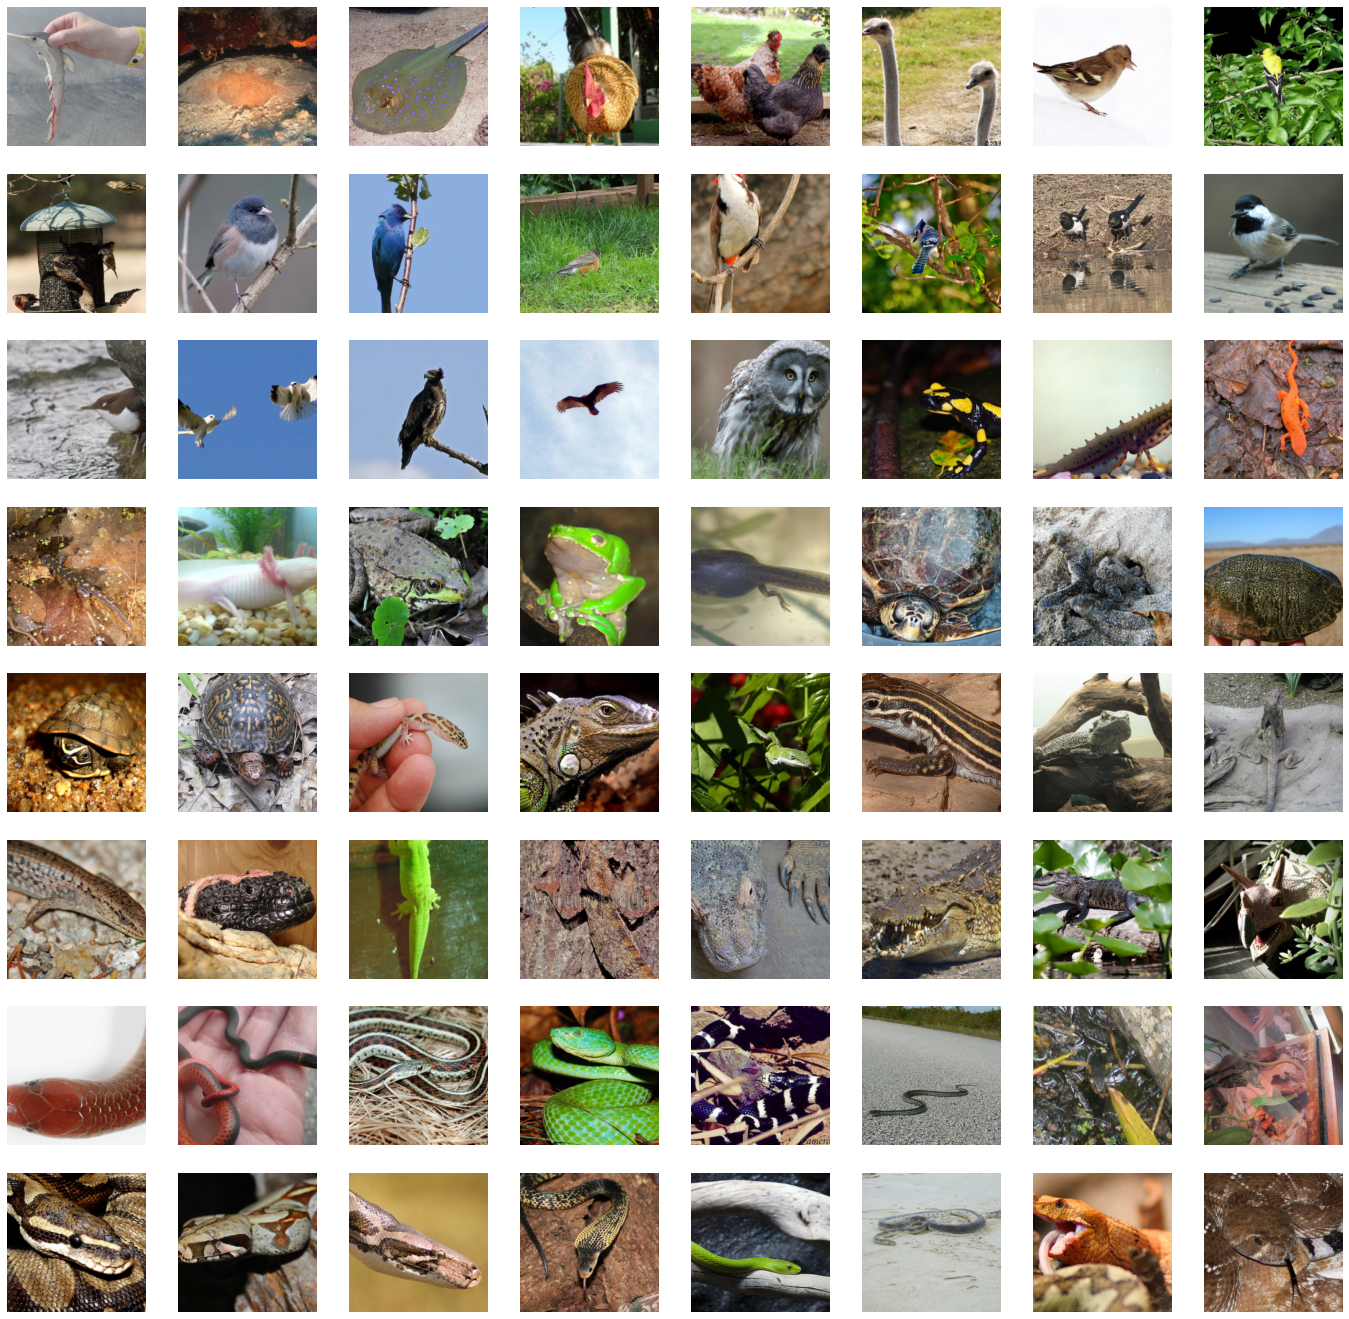

In [7]:
user.plot(true_user_data)

# Reconstruct user data

In [8]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

[('hammerhead', 'hammerhead shark'), ('electric ray', 'crampfish', 'numbfish', 'torpedo'), ('stingray',), ('cock',), ('hen',), ('ostrich', 'Struthio camelus'), ('brambling', 'Fringilla montifringilla'), ('goldfinch', 'Carduelis carduelis'), ('house finch', 'linnet', 'Carpodacus mexicanus'), ('junco', 'snowbird'), ('indigo bunting', 'indigo finch', 'indigo bird', 'Passerina cyanea'), ('robin', 'American robin', 'Turdus migratorius'), ('bulbul',), ('jay',), ('magpie',), ('chickadee',), ('water ouzel', 'dipper'), ('kite',), ('bald eagle', 'American eagle', 'Haliaeetus leucocephalus'), ('vulture',), ('great grey owl', 'great gray owl', 'Strix nebulosa'), ('European fire salamander', 'Salamandra salamandra'), ('common newt', 'Triturus vulgaris'), ('eft',), ('spotted salamander', 'Ambystoma maculatum'), ('axolotl', 'mud puppy', 'Ambystoma mexicanum'), ('bullfrog', 'Rana catesbeiana'), ('tree frog', 'tree-frog'), ('tailed frog', 'bell toad', 'ribbed toad', 'tailed toad', 'Ascaphus trui'), ('l

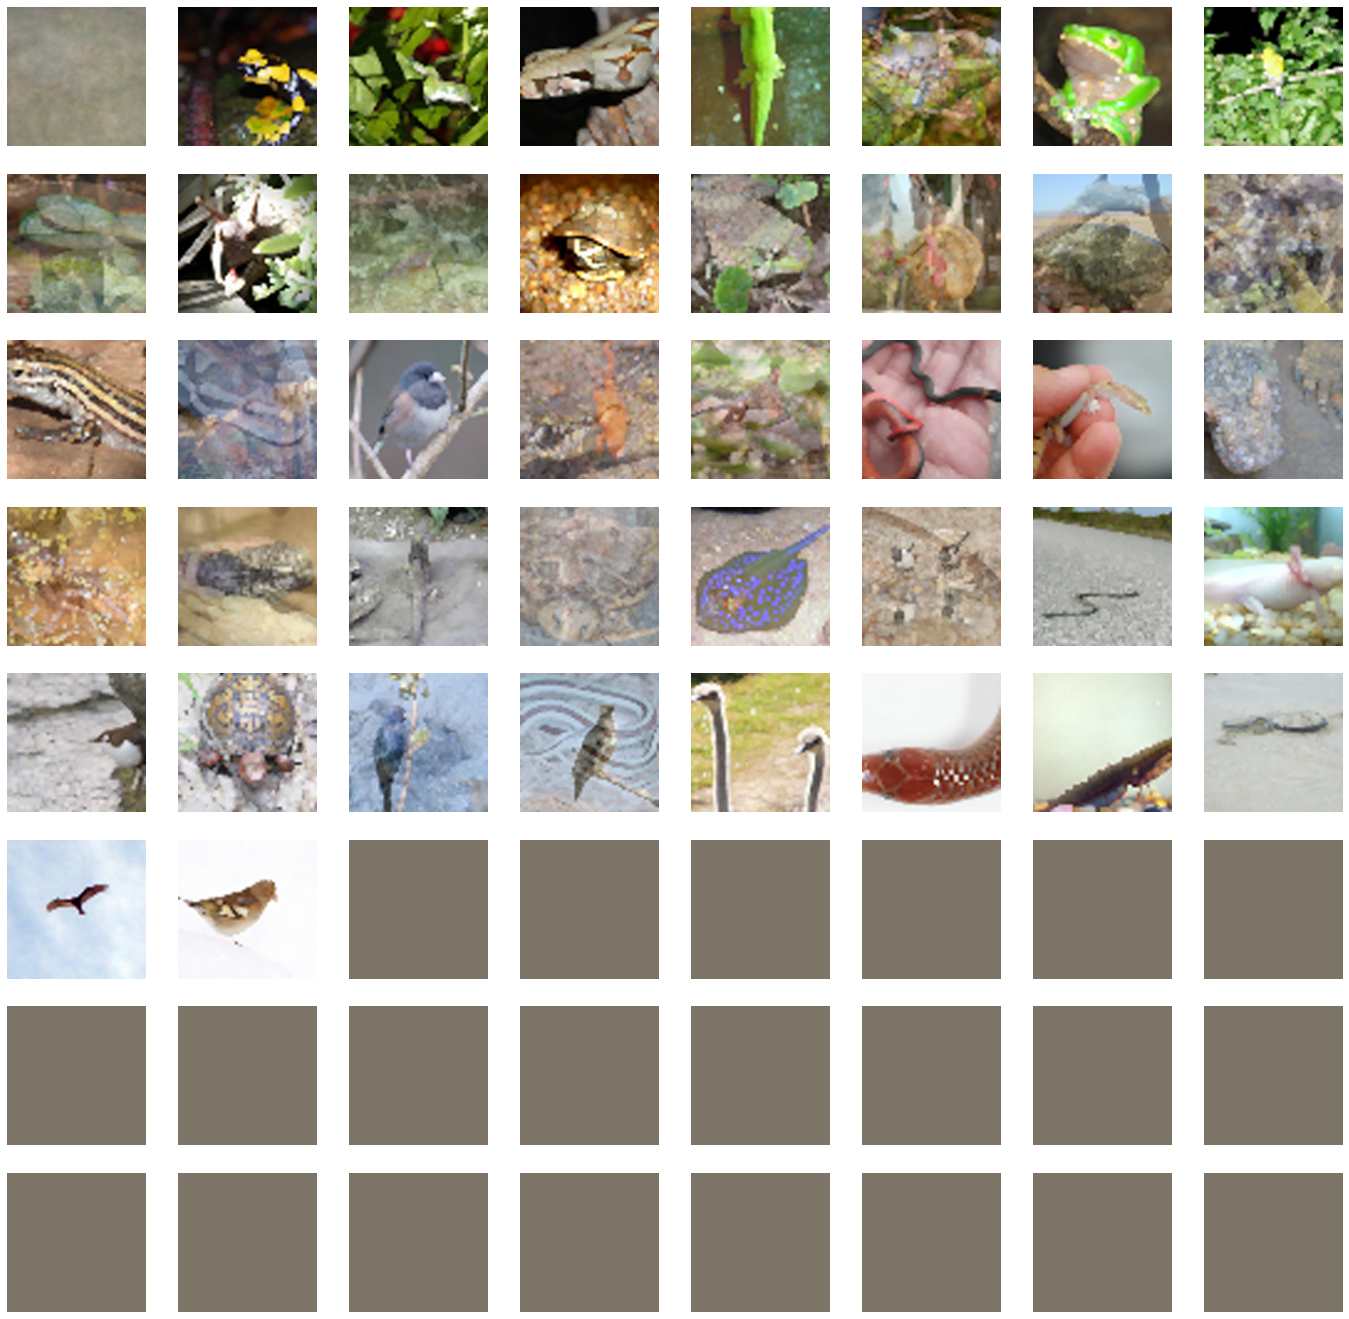

In [9]:
user.plot(reconstructed_user_data, scale=False)

In [10]:
# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False, skip_rpsnr=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jonas/anaconda3/envs/dl/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0397 | PSNR: 15.15 | FMSE: 5.8827e+02 | LPIPS: 0.69| R-PSNR:  nan | IIP-pixel: 50.00%


[('hognose snake', 'puff adder', 'sand viper'), ('thunder snake', 'worm snake', 'Carphophis amoenus'), ('tailed frog', 'bell toad', 'ribbed toad', 'tailed toad', 'Ascaphus trui'), ('jay',), ('green snake', 'grass snake'), ('American chameleon', 'anole', 'Anolis carolinensis'), ('Gila monster', 'Heloderma suspectum'), ('goldfinch', 'Carduelis carduelis'), ('ringneck snake', 'ring-necked snake', 'ring snake'), ('bald eagle', 'American eagle', 'Haliaeetus leucocephalus'), ('American alligator', 'Alligator mississipiensis'), ('garter snake', 'grass snake'), ('indigo bunting', 'indigo finch', 'indigo bird', 'Passerina cyanea'), ('ostrich', 'Struthio camelus'), ('triceratops',), ('green lizard', 'Lacerta viridis'), ('terrapin',), ('African chameleon', 'Chamaeleo chamaeleon'), ('Komodo dragon', 'Komodo lizard', 'dragon lizard', 'giant lizard', 'Varanus komodoensis'), ('alligator lizard',), ('African crocodile', 'Nile crocodile', 'Crocodylus niloticus'), ('electric ray', 'crampfish', 'numbfish

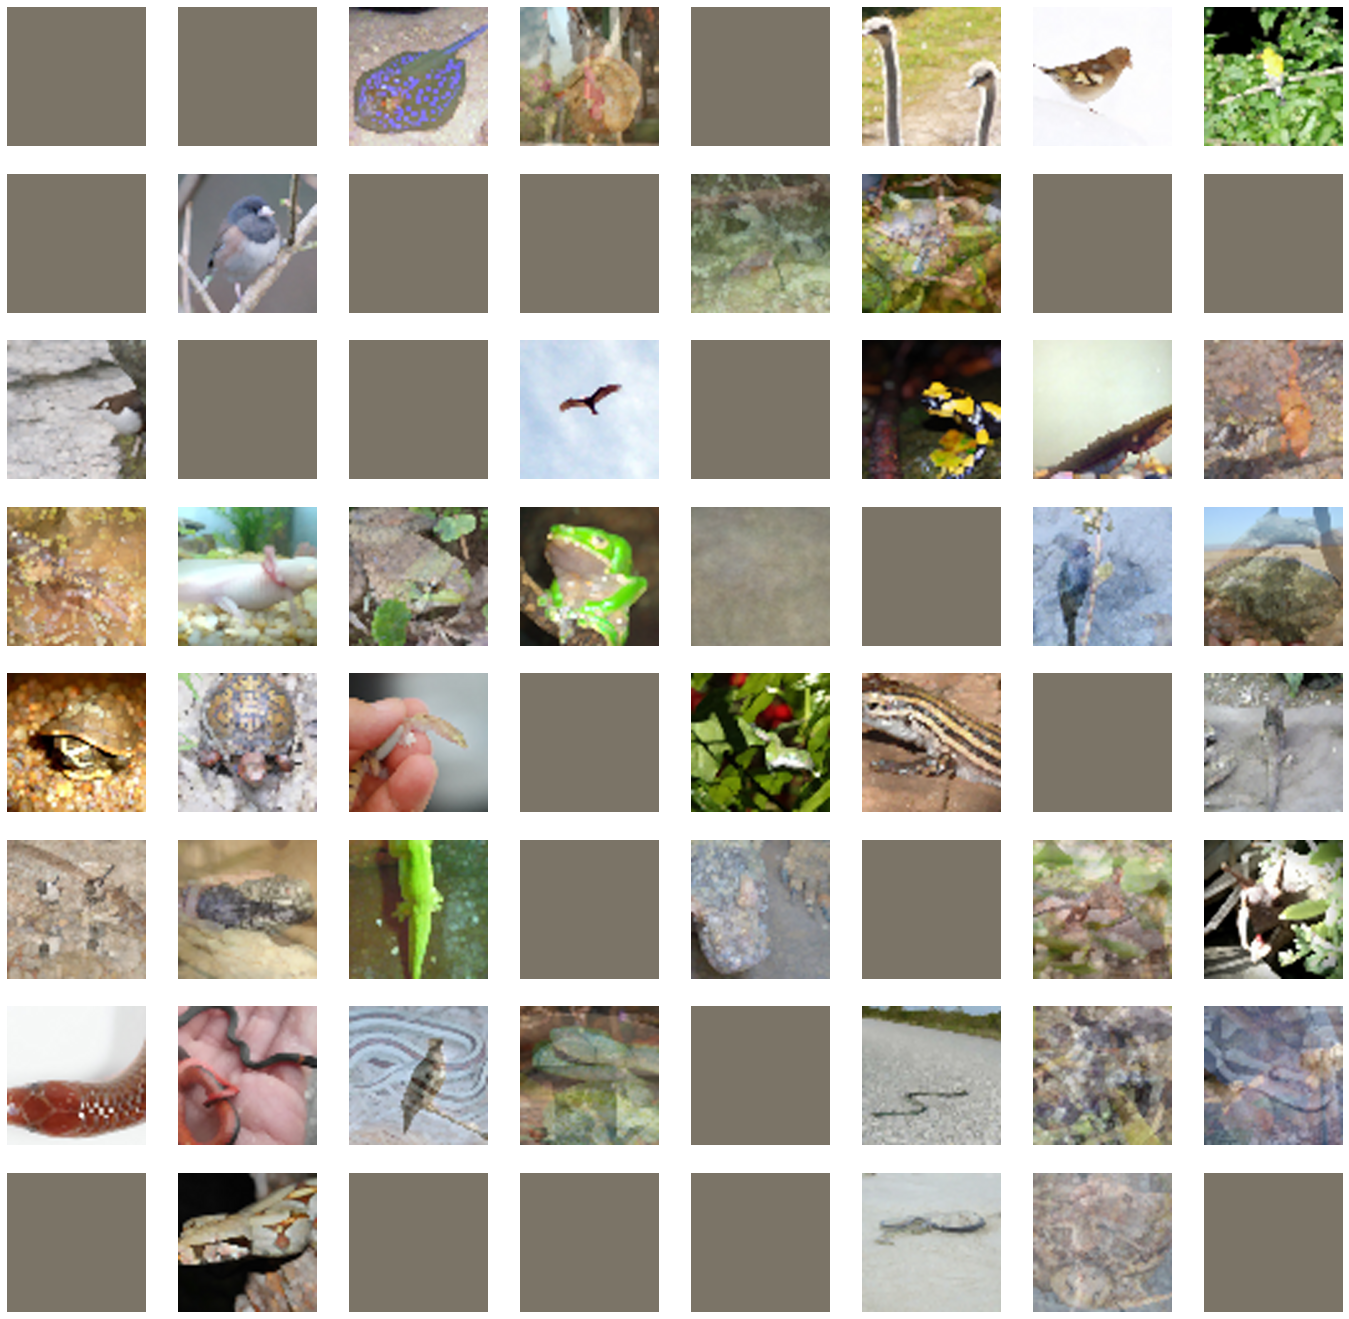

In [11]:
user.plot(reconstructed_user_data, scale=False)